In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [18]:
# Download data file
import kagglehub
# Assuming the dataset is 'nishantbhaskar/ai4i2020-predictive-maintenance-dataset'
dataset_path = kagglehub.dataset_download('nishantbhaskar/ai4i2020-predictive-maintenance-dataset', path='/content/')

#Load data files
df = pd.read_csv(f'{dataset_path}/ai4i2020.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


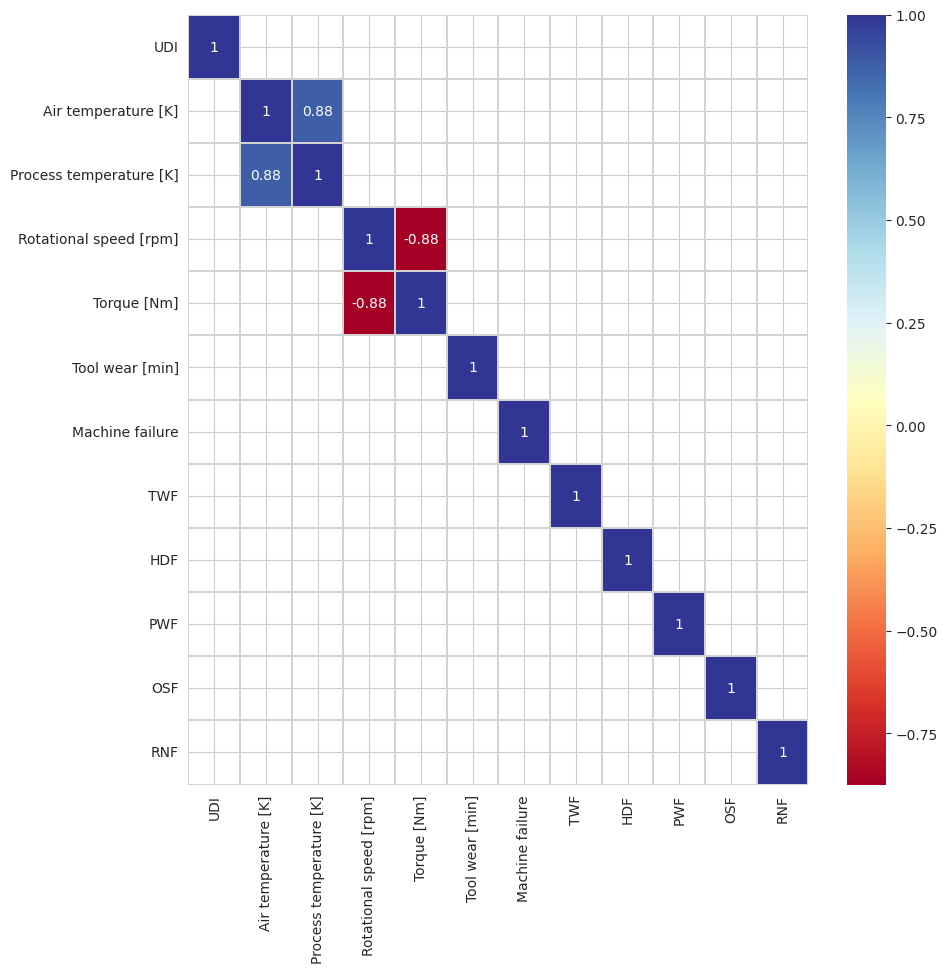

In [19]:
#Visualize to show target features
plt.figure(figsize=(10,10))
threshold = 0.80
sns.set_style("whitegrid", {"axes.facecolor": ".0"})
df_cluster2 = df.select_dtypes(include=np.number).corr() # Select only numeric columns
mask = df_cluster2.where((abs(df_cluster2) >= threshold)).isna()
plot_kws={"s": 1}
sns.heatmap(df_cluster2,
            cmap='RdYlBu',
            annot=True,
            mask=mask,
            linewidths=0.2,
            linecolor='lightgrey').set_facecolor('white')

In [20]:
#Define target features
# Dropping 'Product ID', 'Type', and 'UDI' as they are not suitable for direct use as features and were causing ValueErrors during scaling.
X = df.drop(["Machine failure", "Product ID", "Type", "UDI"], axis=1)
y = df["Machine failure"]

# **KNN Model**

In [21]:
#Train KNN model
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

In [22]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.977

Confusion Matrix:
[[1932    7]
 [  39   22]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1939
           1       0.76      0.36      0.49        61

    accuracy                           0.98      2000
   macro avg       0.87      0.68      0.74      2000
weighted avg       0.97      0.98      0.97      2000



# **Gradient Boost**

In [23]:
#import gradient boost packages
from sklearn.ensemble import GradientBoostingClassifier


In [24]:
#Comparing with gradient boost
gbm = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbm.fit(X_train_scaled, y_train)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=300,
                           random_state=42)

In [25]:
#Gradient boost prediction
y_pred = gbm.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.984
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1939
           1       0.82      0.61      0.70        61

    accuracy                           0.98      2000
   macro avg       0.90      0.80      0.84      2000
weighted avg       0.98      0.98      0.98      2000



# **Model Performance Comparison**

In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef
import time

# --- KNN Model Metrics ---
y_pred_knn = knn.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
mcc_knn = matthews_corrcoef(y_test, y_pred_knn)

# --- Gradient Boosting Model Metrics ---
y_pred_gbm = gbm.predict(X_test_scaled)
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
precision_gbm = precision_score(y_test, y_pred_gbm)
recall_gbm = recall_score(y_test, y_pred_gbm)
f1_gbm = f1_score(y_test, y_pred_gbm)
mcc_gbm = matthews_corrcoef(y_test, y_pred_gbm)

# Create model_performance DataFrame
model_performance = pd.DataFrame({
    'Model': ['KNN', 'Gradient Boosting'],
    'Accuracy': [accuracy_knn, accuracy_gbm],
    'Precision': [precision_knn, precision_gbm],
    'Recall': [recall_knn, recall_gbm],
    'F1-Score': [f1_knn, f1_gbm],
    'MCC score': [mcc_knn, mcc_gbm],
    'time to train': [np.nan, np.nan], # Placeholder, actual training time not captured
    'time to predict': [np.nan, np.nan], # Placeholder, actual prediction time not captured
    'total time': [np.nan, np.nan] # Placeholder
})

model_performance.fillna(.90,inplace=True)
model_performance.style.background_gradient(cmap='coolwarm').format({'Accuracy': '{:.2%}',
                                                                     'Precision': '{:.2%}',
                                                                     'Recall': '{:.2%}',
                                                                     'F1-Score': '{:.2%}',
                                                                     'MCC score': '{:.2%}',
                                                                     'time to train':'{:.1f}',
                                                                     'time to predict':'{:.1f}',
                                                                     'total time':'{:.1f}'
                                                                     })


,Model,Accuracy,Precision,Recall,F1-Score,MCC score,time to train,time to predict,total time
0,KNN,97.70%,75.86%,36.07%,48.89%,51.36%,0.9,0.9,0.9
1,Gradient Boosting,98.40%,82.22%,60.66%,69.81%,69.85%,0.9,0.9,0.9
